# Keras ClassificationPractice - Tuncay Celik

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.shape

(10000, 13)

In [6]:
df.isnull().sum().any()

False

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.000,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


                                             |                                             | [  0%]   00:00 ->…


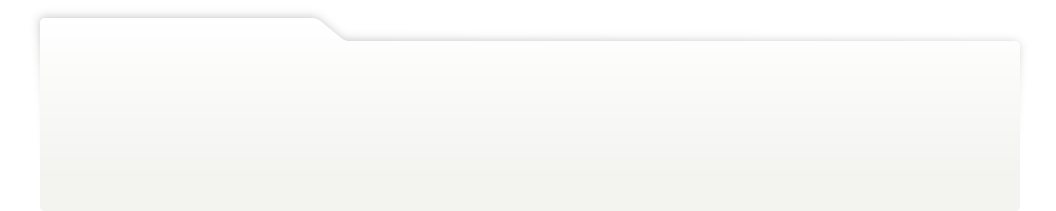
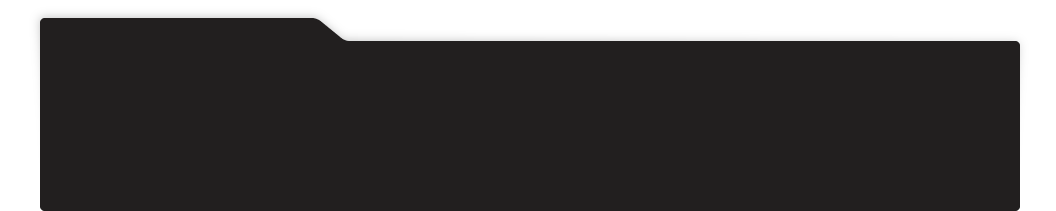
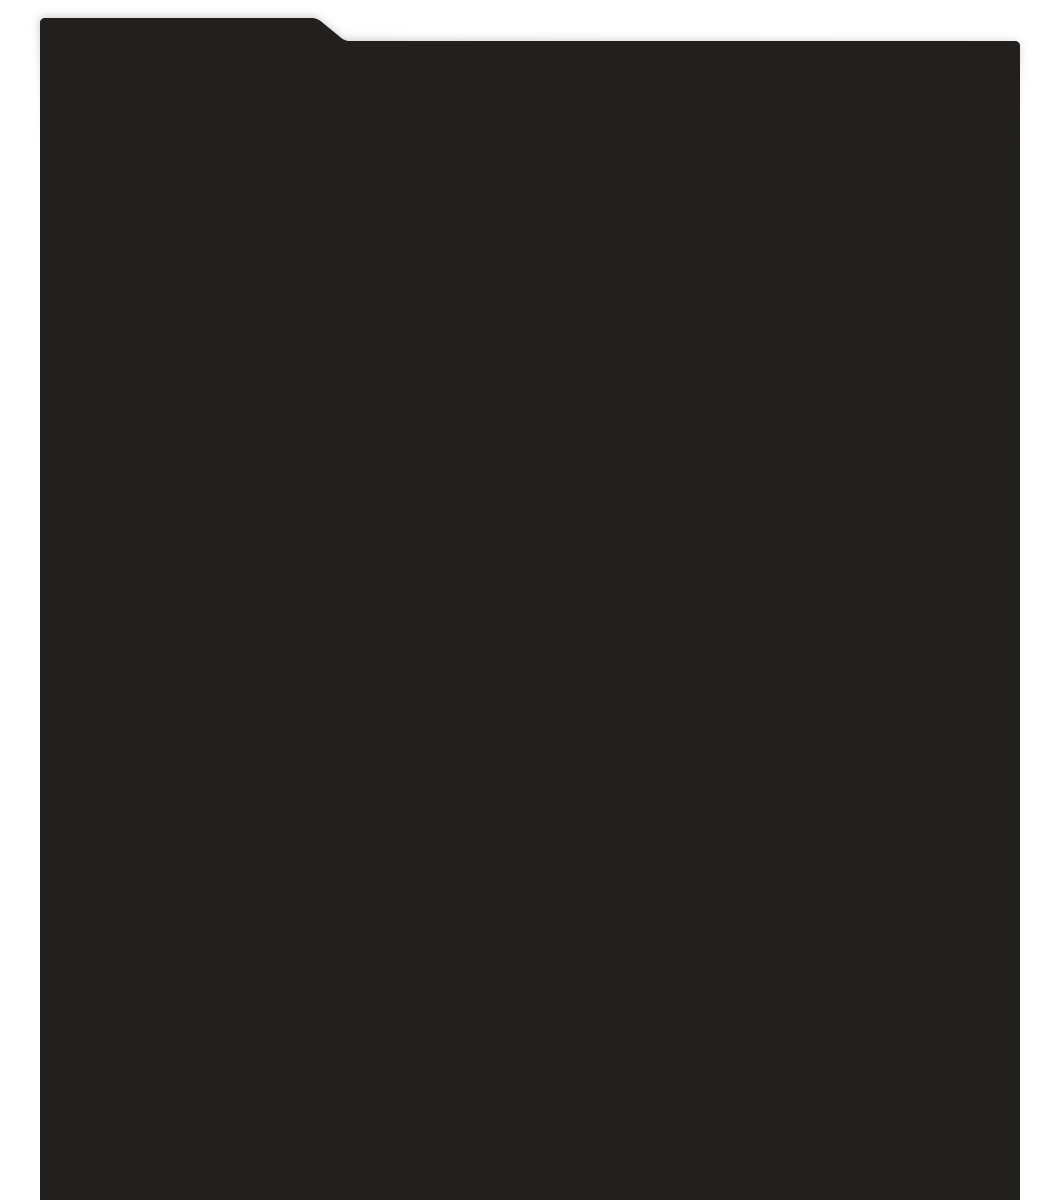
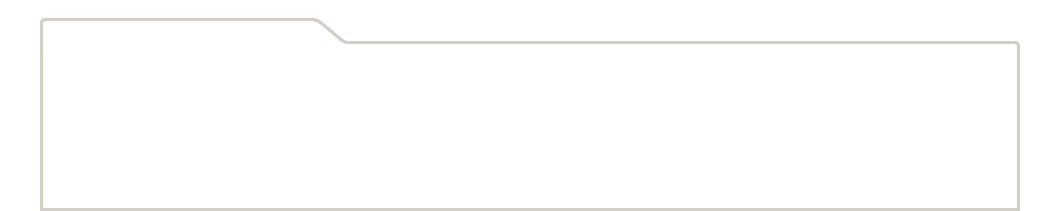
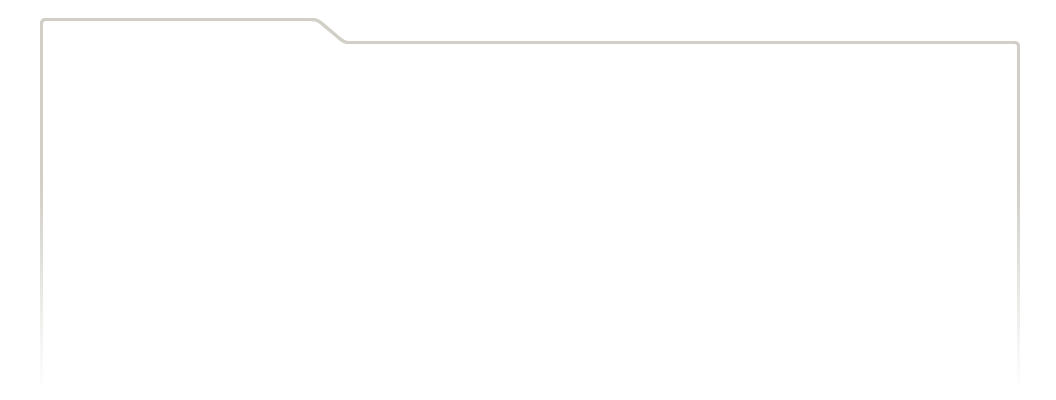
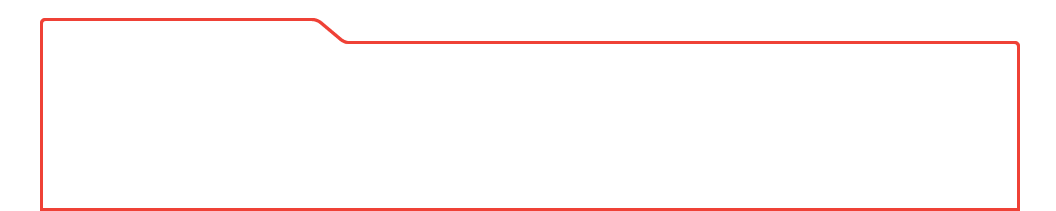
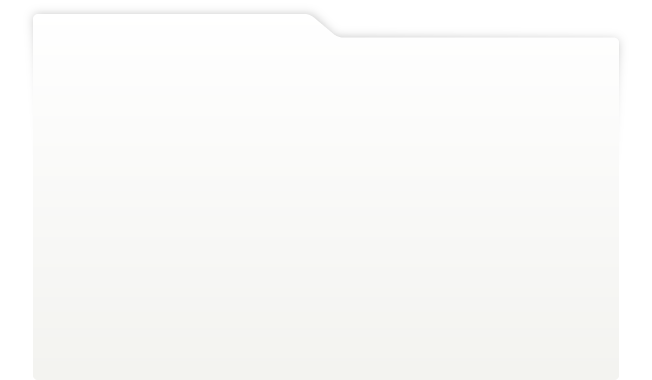
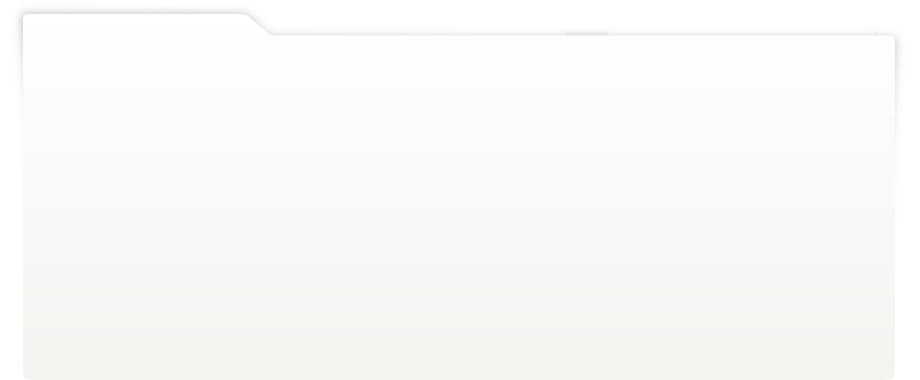
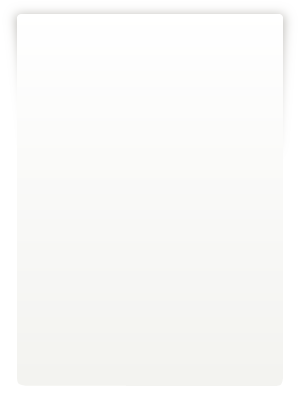
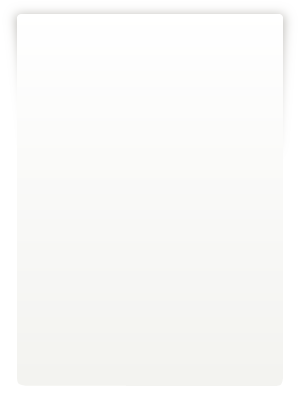
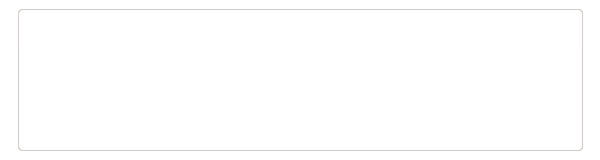
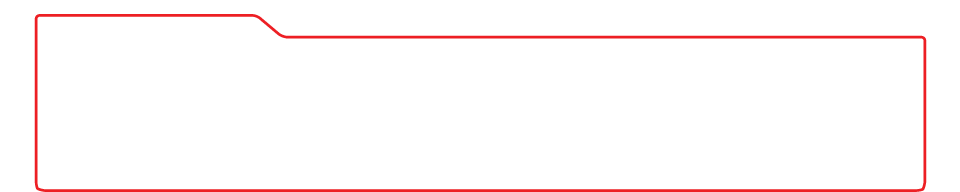
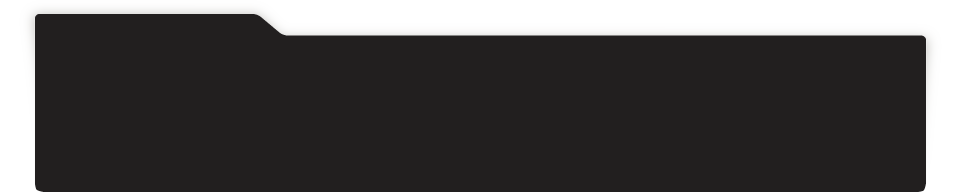
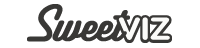
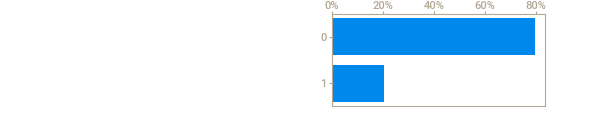
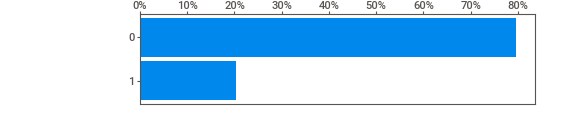
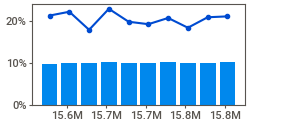
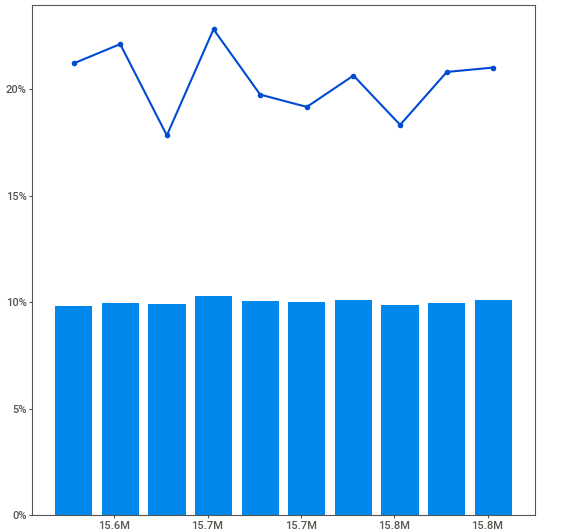
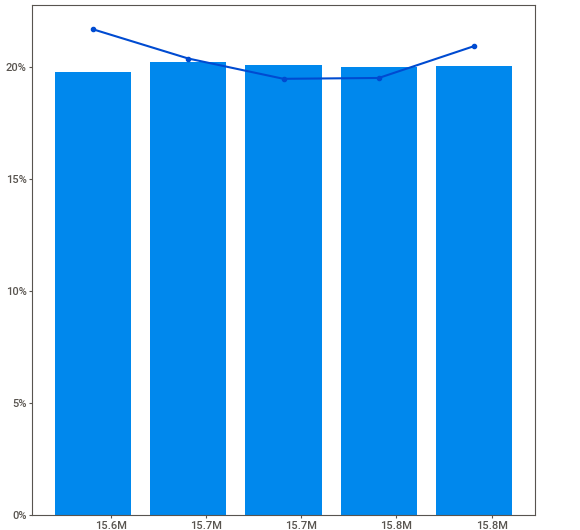
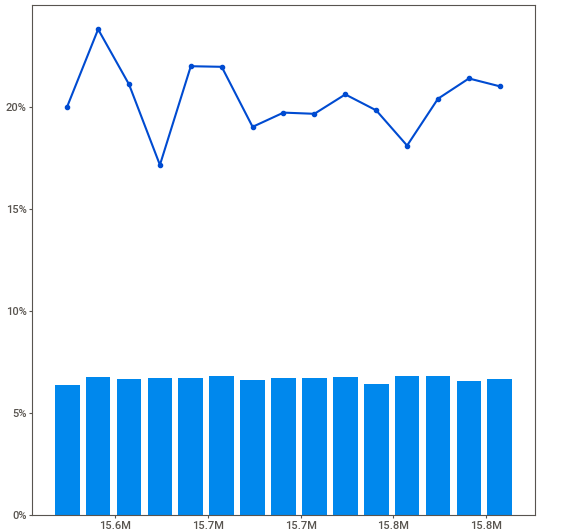
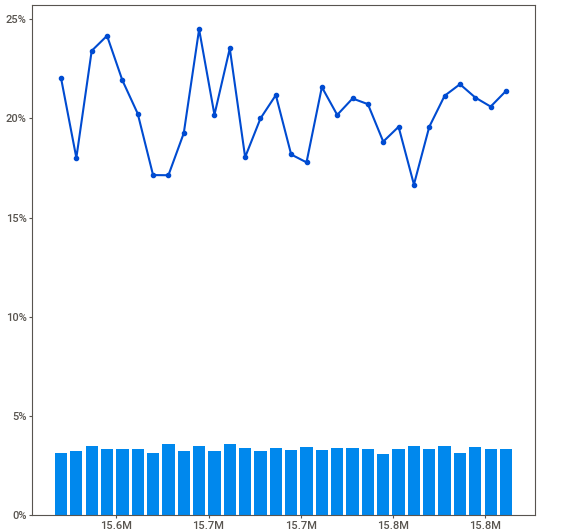
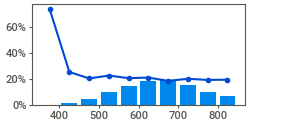
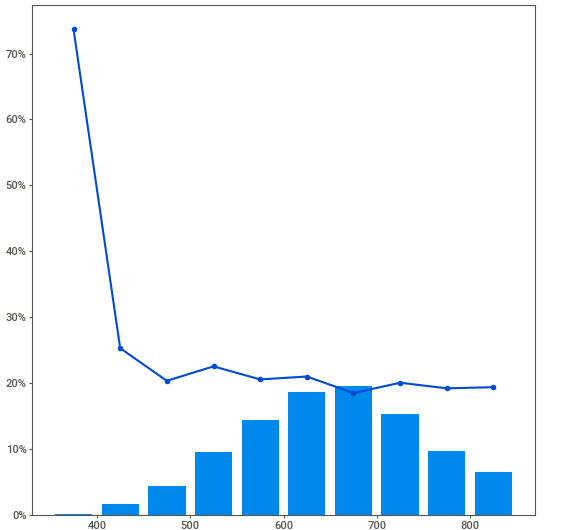
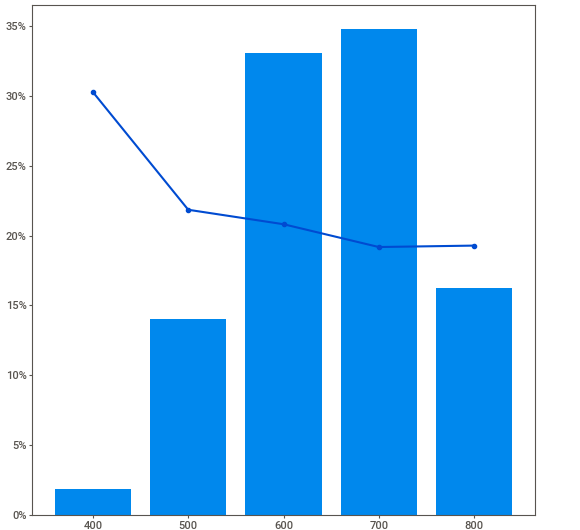
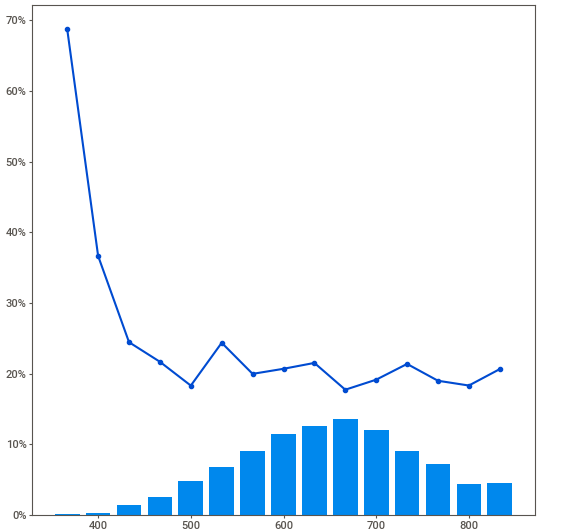
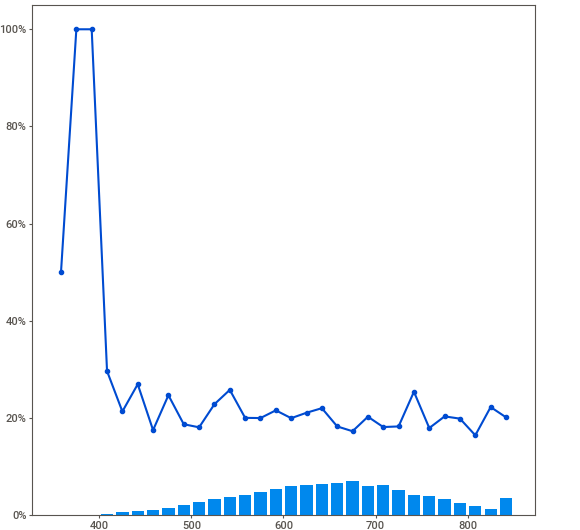
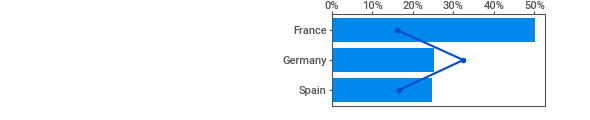
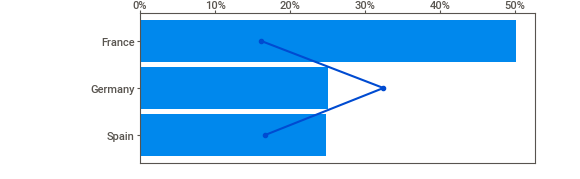
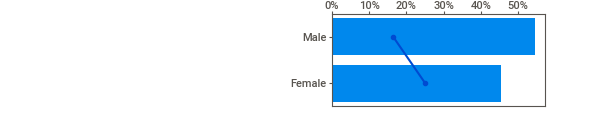
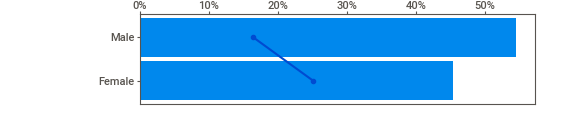
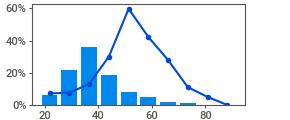
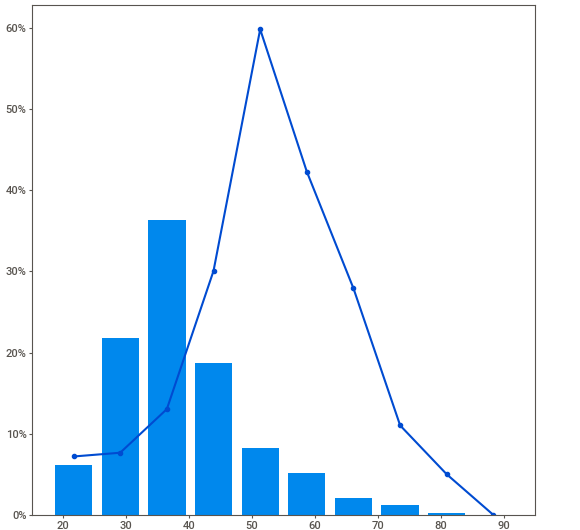
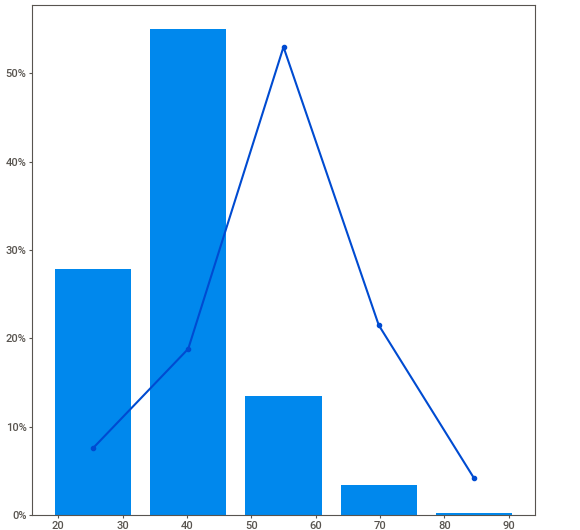
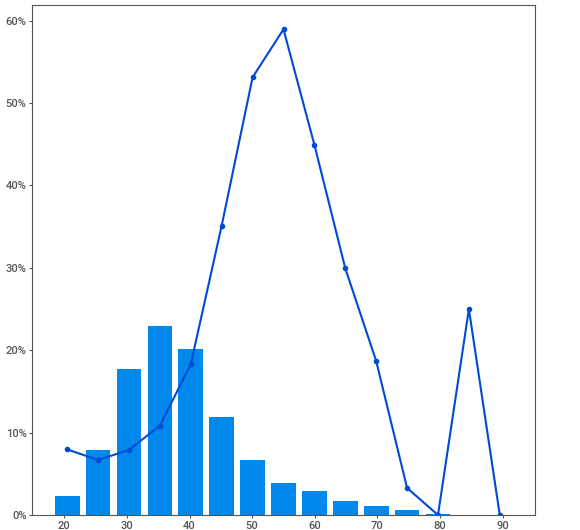
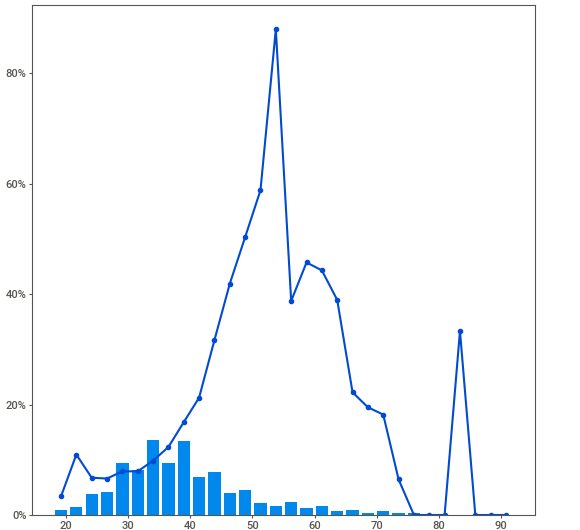
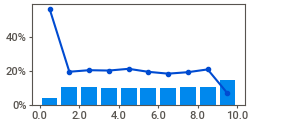
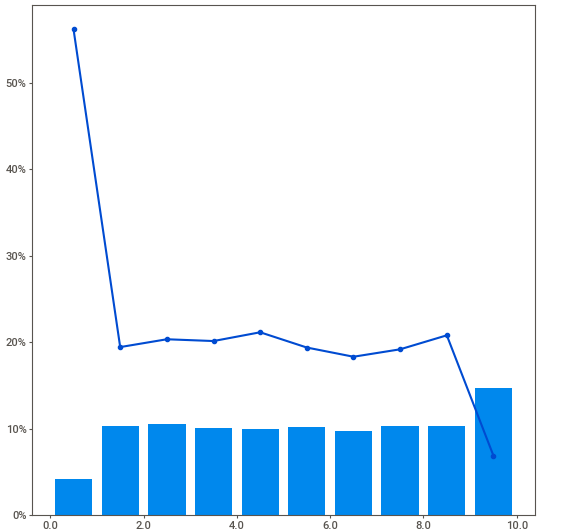
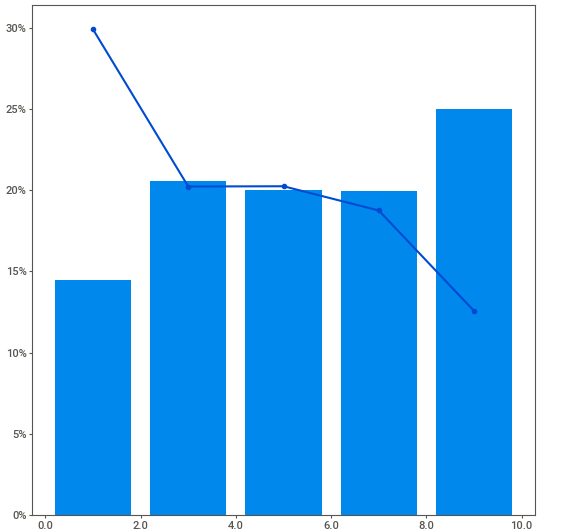
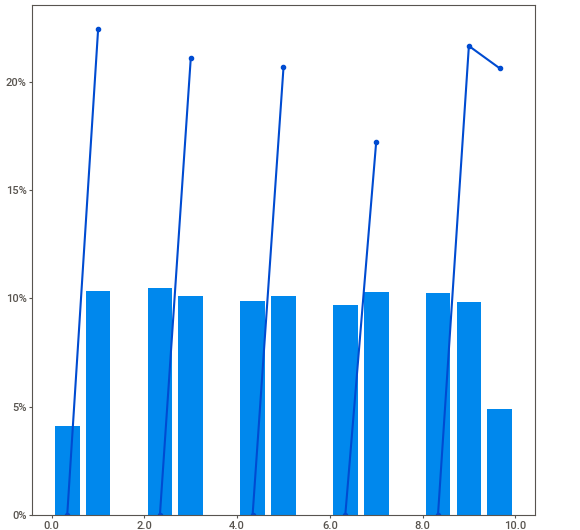
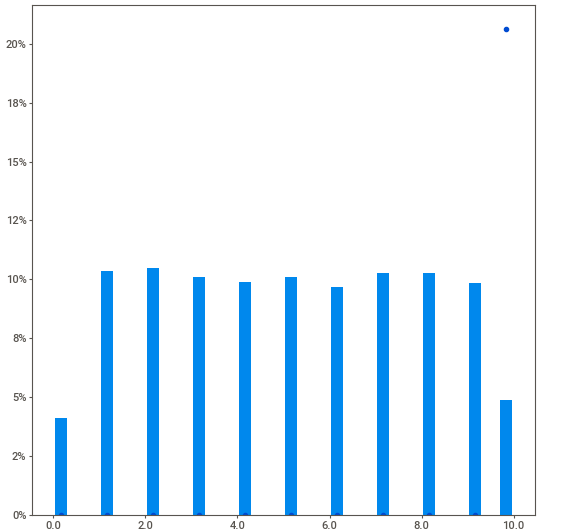
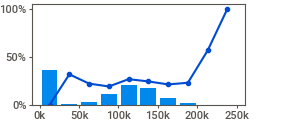
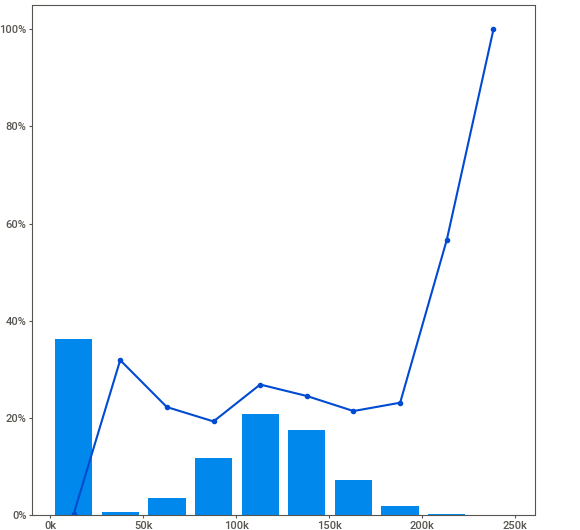
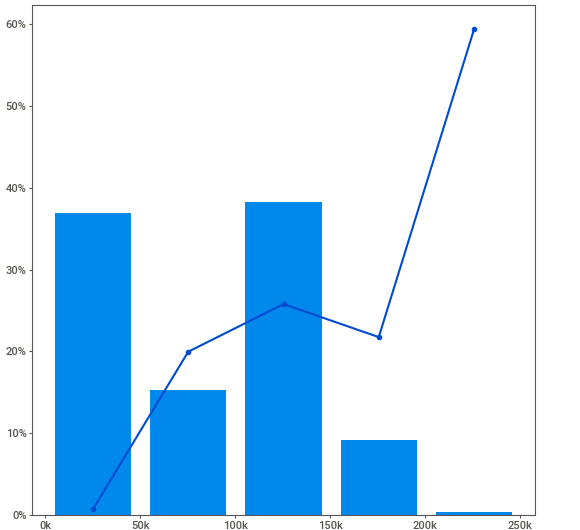
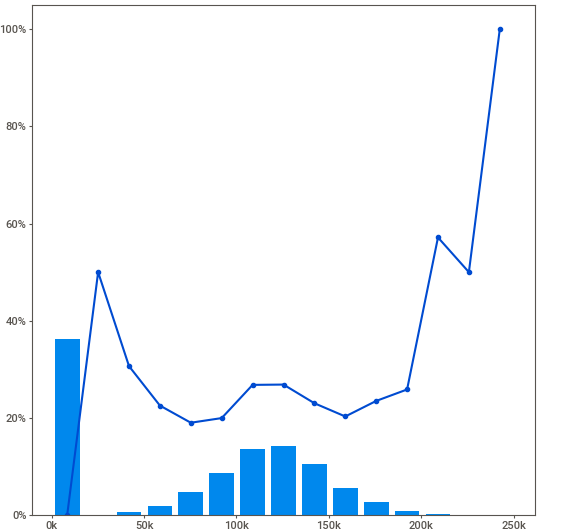
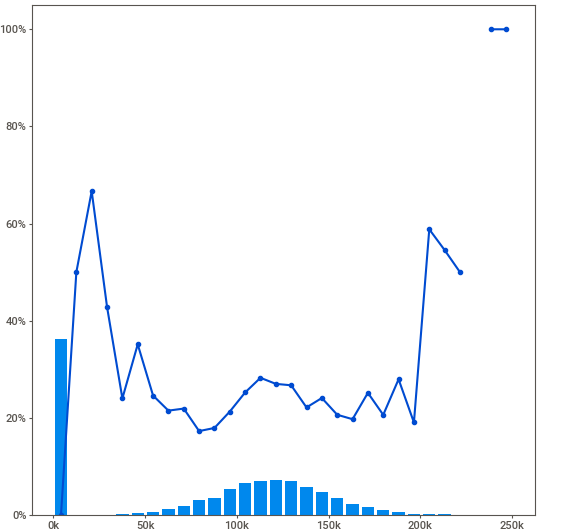
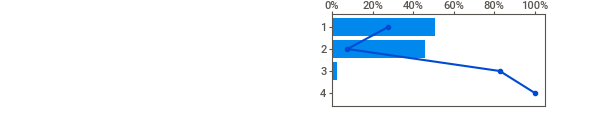
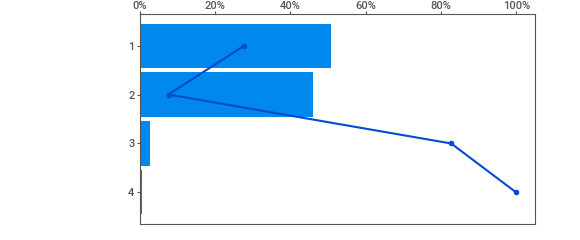
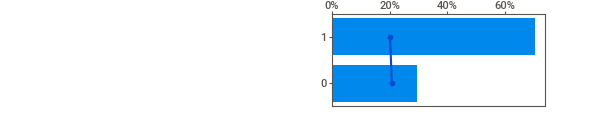
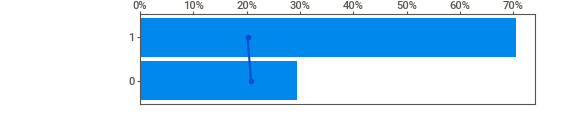
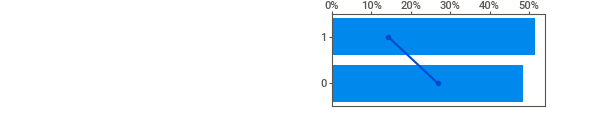
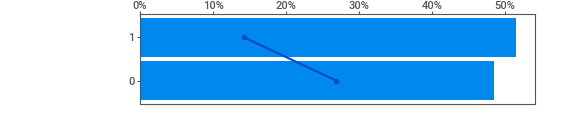
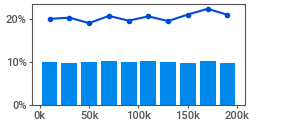
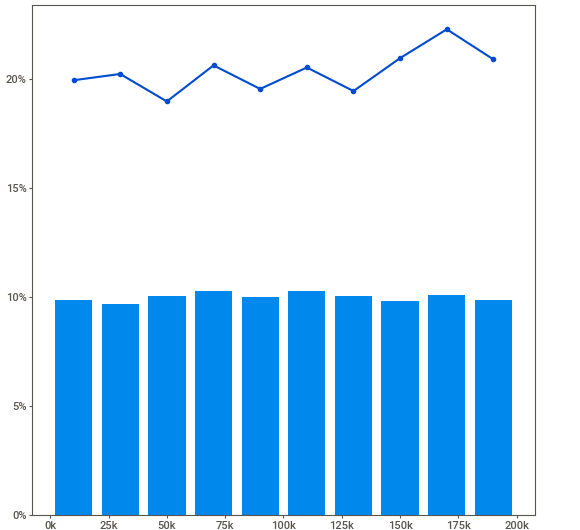
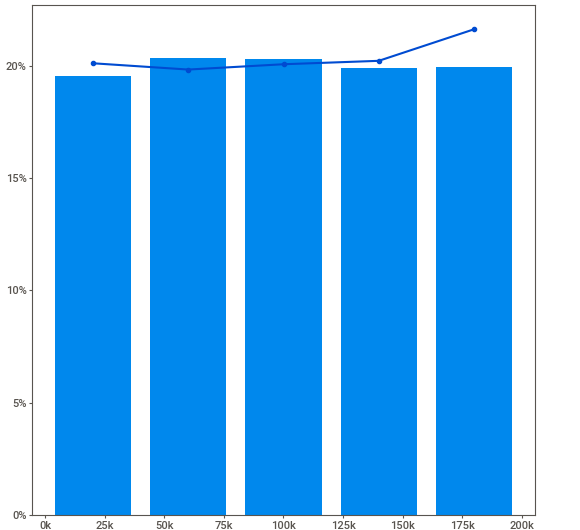
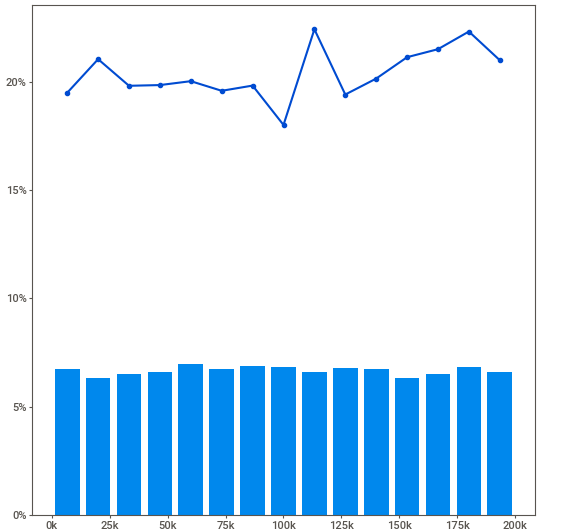
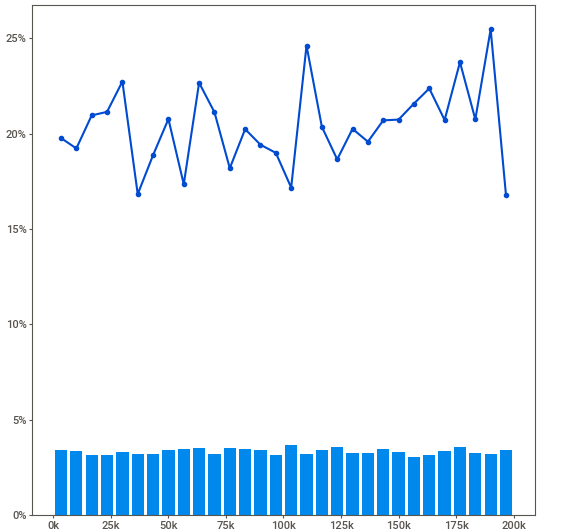
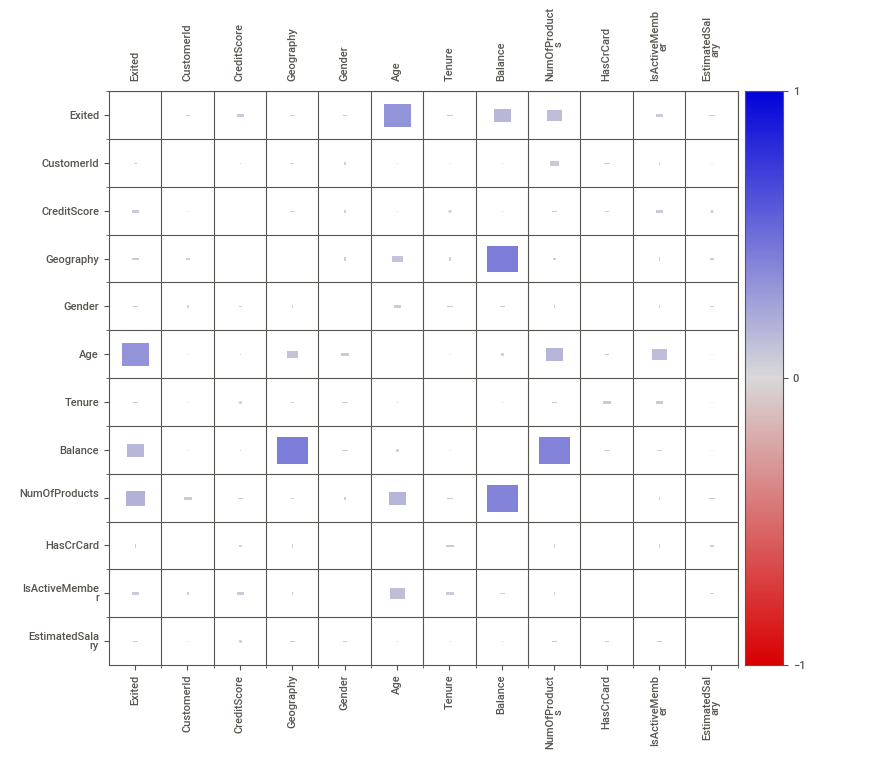
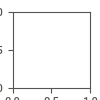

In [9]:
import sweetviz 

my_report = sweetviz.analyze([df, "original data"],target_feat='Exited')

my_report.show_notebook(layout="vertical", w ="980", h= 700, scale= .8)

<AxesSubplot:>

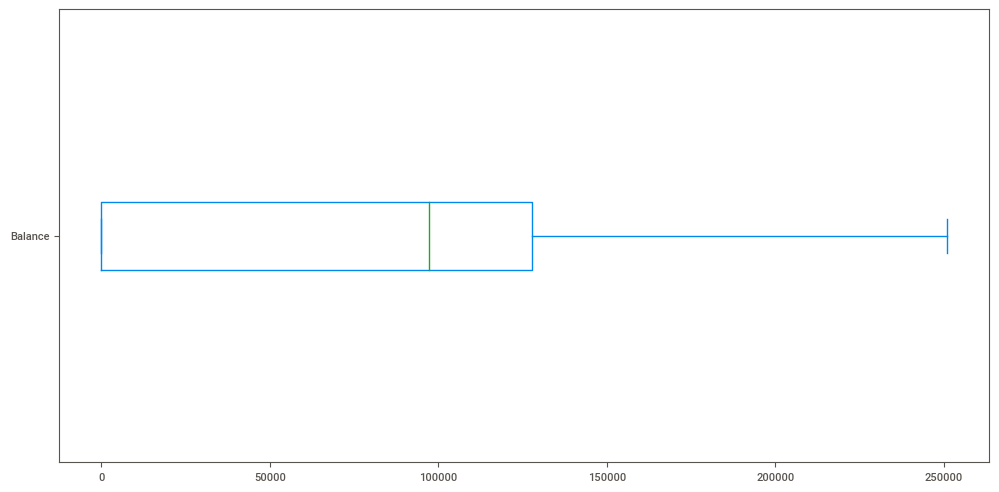

In [10]:
df.Balance.plot(kind="box",vert=False)

In [11]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


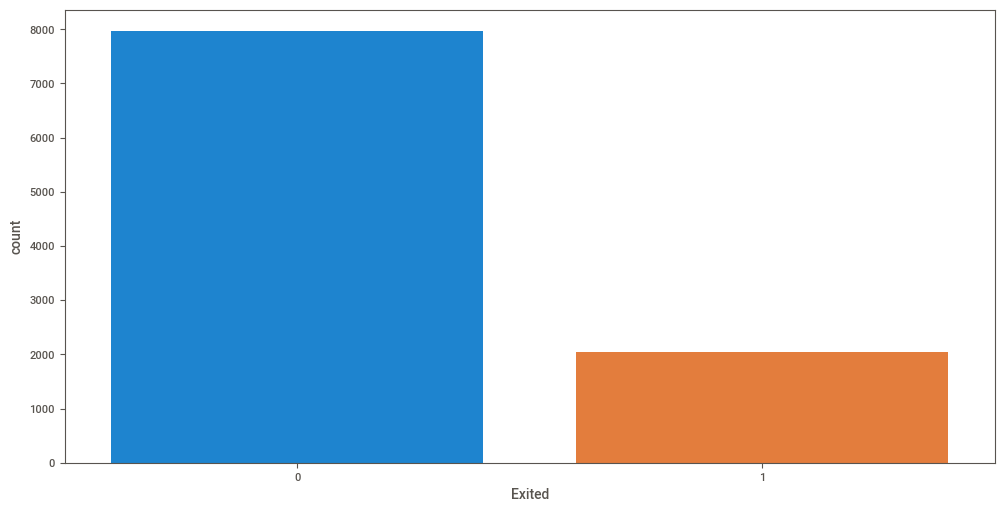

In [12]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

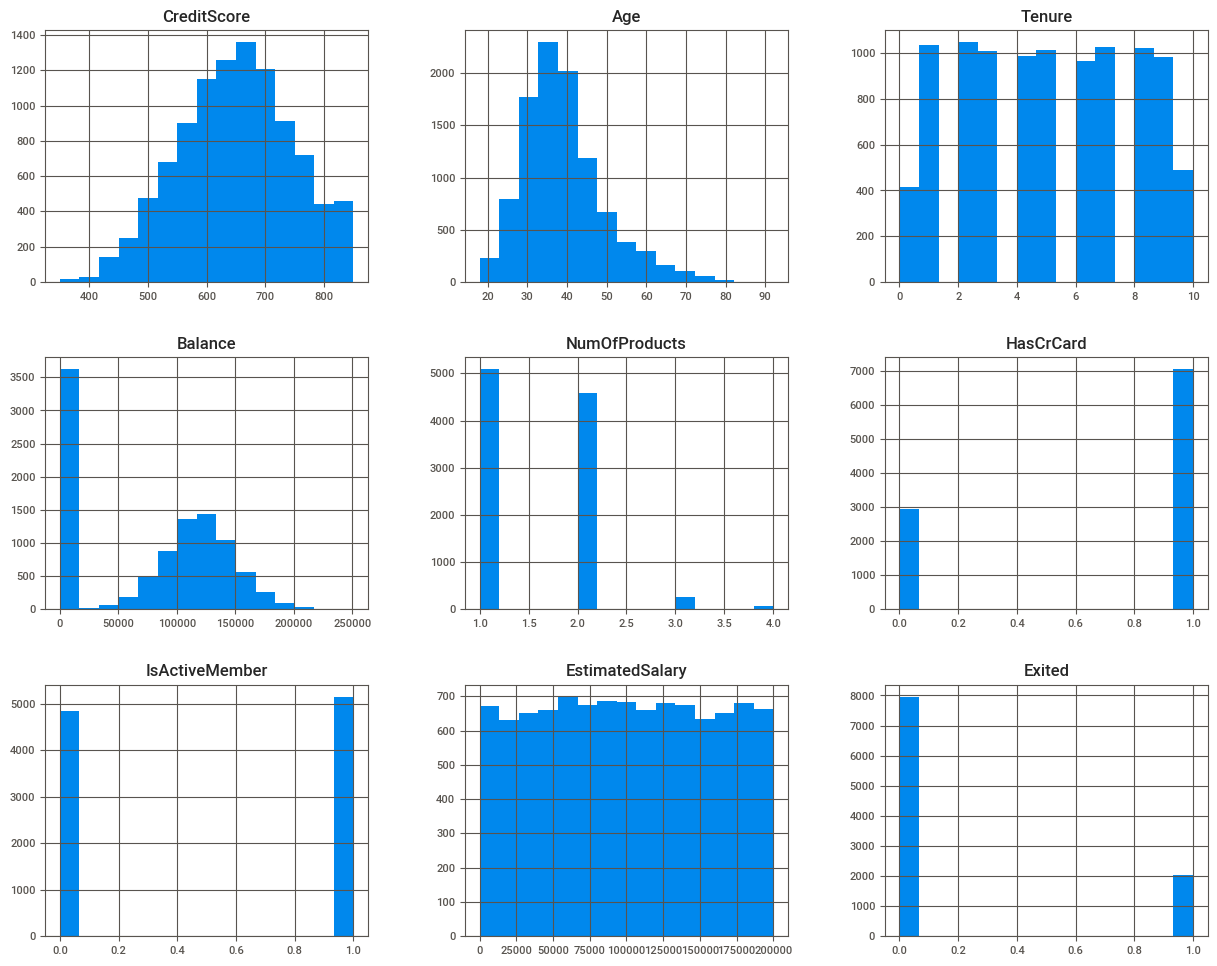

In [13]:
df.hist(figsize=(15, 12), bins=15);


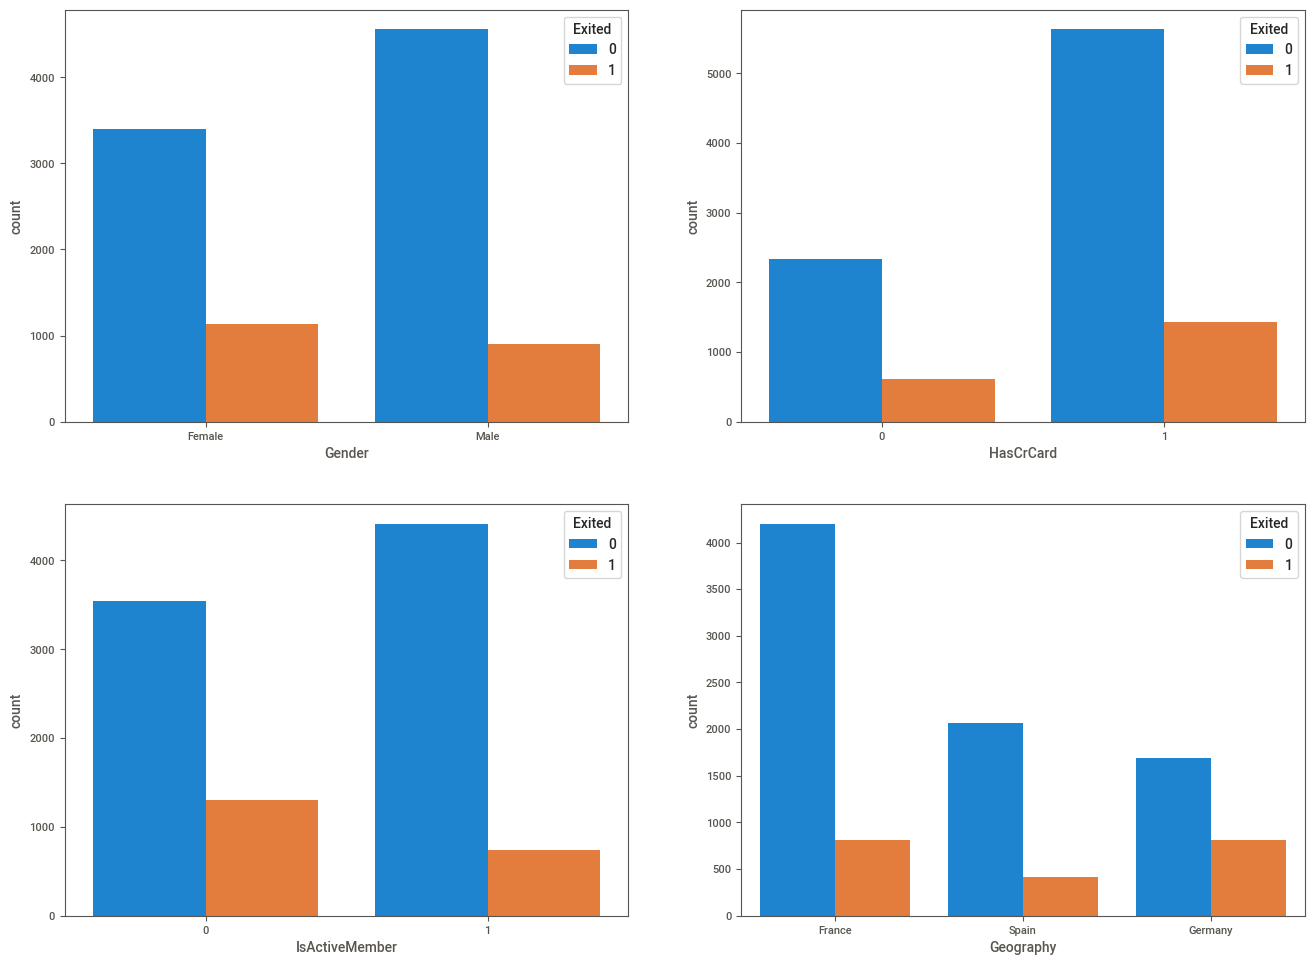

In [14]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [15]:
df.groupby("Age")["Exited"].value_counts()


Age  Exited
18   0         20
     1          2
19   0         26
     1          1
20   0         38
               ..
84   0          1
     1          1
85   0          1
88   0          1
92   0          2
Name: Exited, Length: 128, dtype: int64

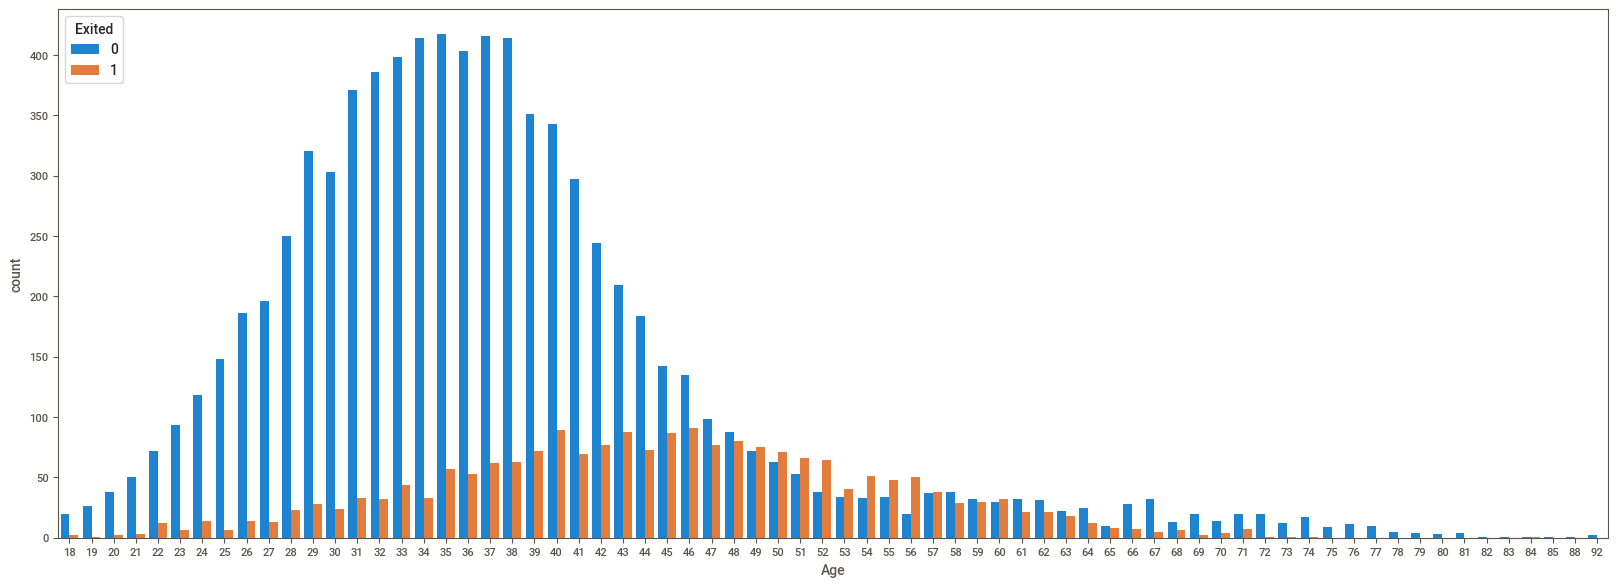

In [16]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [17]:
df.CreditScore.describe()

count   10000.000
mean      650.529
std        96.653
min       350.000
25%       584.000
50%       652.000
75%       718.000
max       850.000
Name: CreditScore, dtype: float64

In [18]:
def credit_transformer(x, y):
    if x < 350 and y == 0:
        return 0
    if x < 350 and y > 0:
        return 1
    if x < 718 and y == 0:
        return 2
    if x < 718 and y > 0:
        return 3
    else:
        return 4

In [19]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 3, 2, 4, 3, 4, 3, 2, 3]

In [20]:
df.insert(10, "customer_value", customer_value)

In [21]:
df.customer_value

RowNumber
1        3
2        2
3        3
4        2
5        4
        ..
9996     4
9997     3
9998     2
9999     4
10000    4
Name: customer_value, Length: 10000, dtype: int64

----

<AxesSubplot:>

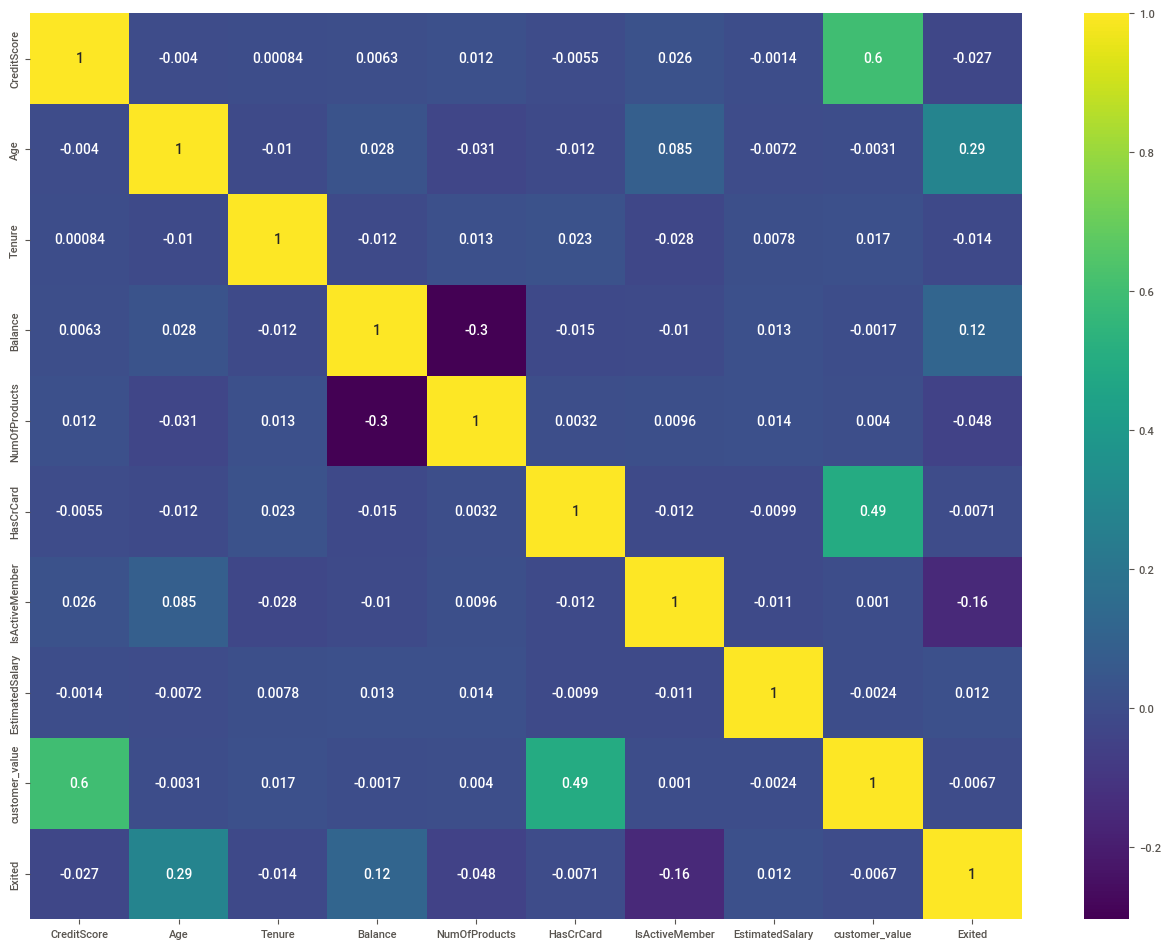

In [22]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

<AxesSubplot:>

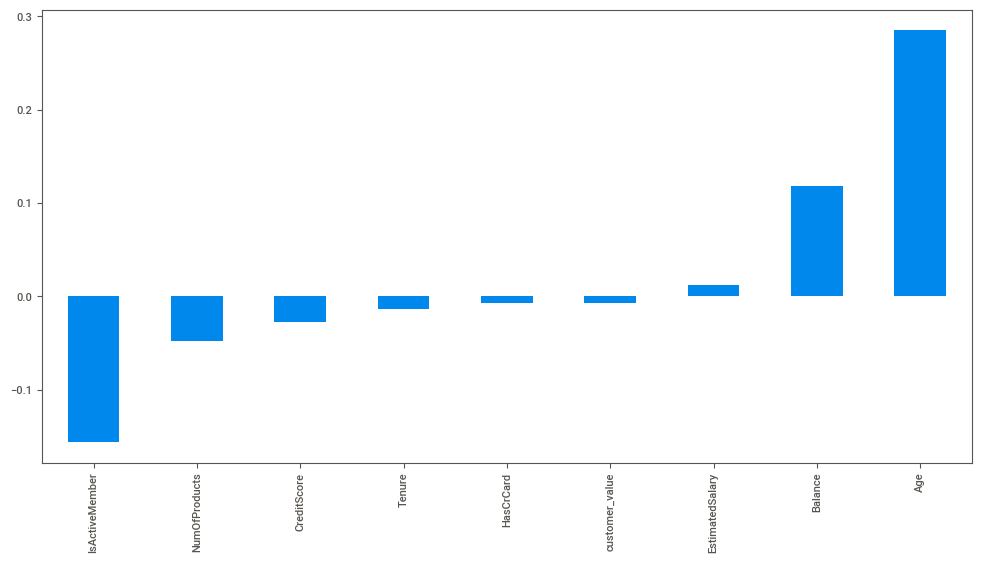

In [23]:
df.corr()['Exited'][:-1].sort_values().plot.bar()

Preprocess

In [24]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,,
1,619,42,2,0.000,1,1,1,101348.880,3,1,0,0,0
2,608,41,1,83807.860,1,0,1,112542.580,2,0,0,1,0
3,502,42,8,159660.800,3,1,0,113931.570,3,1,0,0,0
4,699,39,1,0.000,2,0,0,93826.630,2,0,0,0,0
5,850,43,2,125510.820,1,1,1,79084.100,4,0,0,1,0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [26]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=42)


In [27]:
scaler = MinMaxScaler()


In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Modelling & Model Performance

In [ ]:
tf.random.set_seed(42)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [30]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=11)

In [31]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.5464 - recall: 0.0030 - val_loss: 0.4957 - val_recall: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4932 - recall: 0.0000e+00 - val_loss: 0.4695 - val_recall: 0.0000e+00
Epoch 3/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4759 - recall: 0.0115 - val_loss: 0.4544 - val_recall: 0.0110
Epoch 4/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4668 - recall: 0.0400 - val_loss: 0.4459 - val_recall: 0.0552
Epoch 5/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4611 - recall: 0.0854 - val_loss: 0.4372 - val_recall: 0.1326
Epoch 6/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4549 - recall: 0.0938 - val_loss: 0.4319 - val_recall: 0.0884
Epoch 7/200
64/64 [==============================] - 0s 1ms/step - loss: 0.4500 - recall: 0.1090 - val_loss: 0.4241 - val_recall: 0.1713
Epoch 8/200
64/64 [==========

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

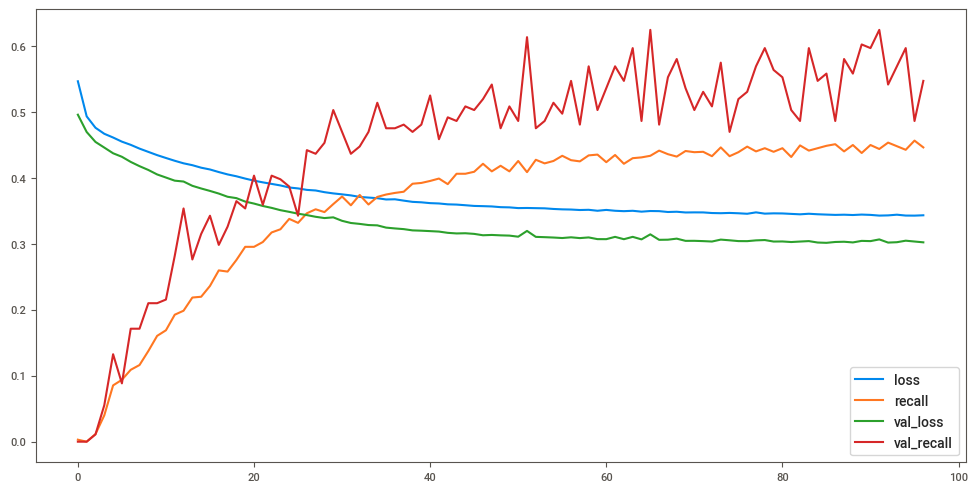

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [34]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[766  30]
 [113  91]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       796
           1       0.75      0.45      0.56       204

    accuracy                           0.86      1000
   macro avg       0.81      0.70      0.74      1000
weighted avg       0.85      0.86      0.84      1000



Receiver Operating Curve and Area Under Curve for model

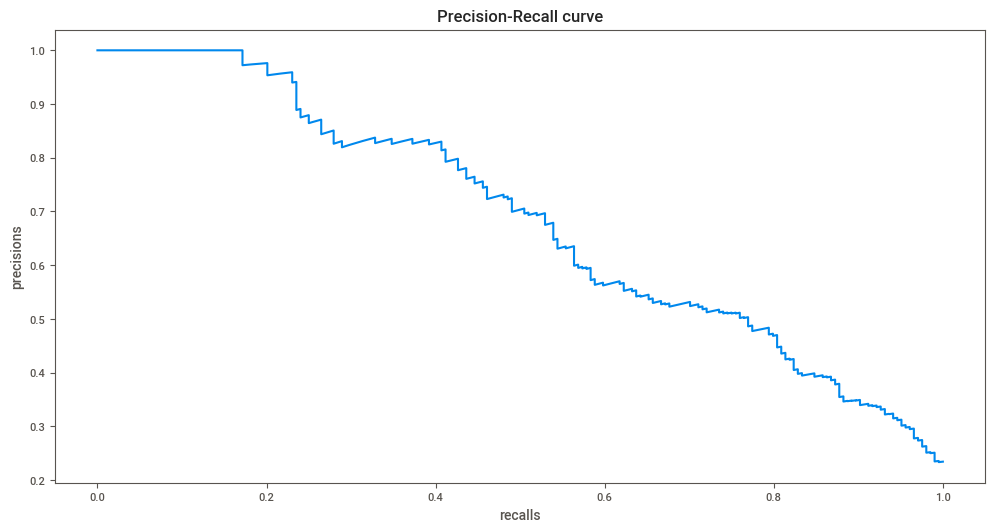

In [35]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [36]:
average_precision_score(y_test, y_pred_proba)

0.6856612020438648

with class_weigth

In [37]:
tf.random.set_seed(42)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [38]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=10)

In [39]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [40]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop],
          class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 1s 3ms/step - loss: 0.6844 - recall: 0.3420 - val_loss: 0.6602 - val_recall: 0.6409
Epoch 2/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6601 - recall: 0.6035 - val_loss: 0.6300 - val_recall: 0.7017
Epoch 3/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6406 - recall: 0.6380 - val_loss: 0.5850 - val_recall: 0.6298
Epoch 4/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6260 - recall: 0.6586 - val_loss: 0.5652 - val_recall: 0.6354
Epoch 5/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6157 - recall: 0.6544 - val_loss: 0.6060 - val_recall: 0.7348
Epoch 6/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6059 - recall: 0.6852 - val_loss: 0.5477 - val_recall: 0.6575
Epoch 7/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5987 - recall: 0.6810 - val_loss: 0.5878 - val_recall: 0.7569
Epoch 8/200
64/64 [======================

<AxesSubplot:>

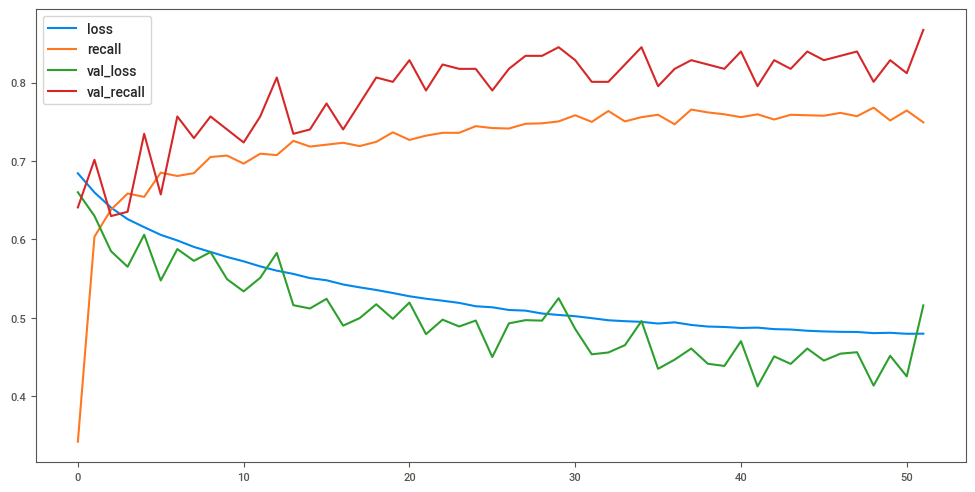

In [41]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [42]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[541 255]
 [ 35 169]]
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       796
           1       0.40      0.83      0.54       204

    accuracy                           0.71      1000
   macro avg       0.67      0.75      0.66      1000
weighted avg       0.83      0.71      0.74      1000



ROC and AUC for model

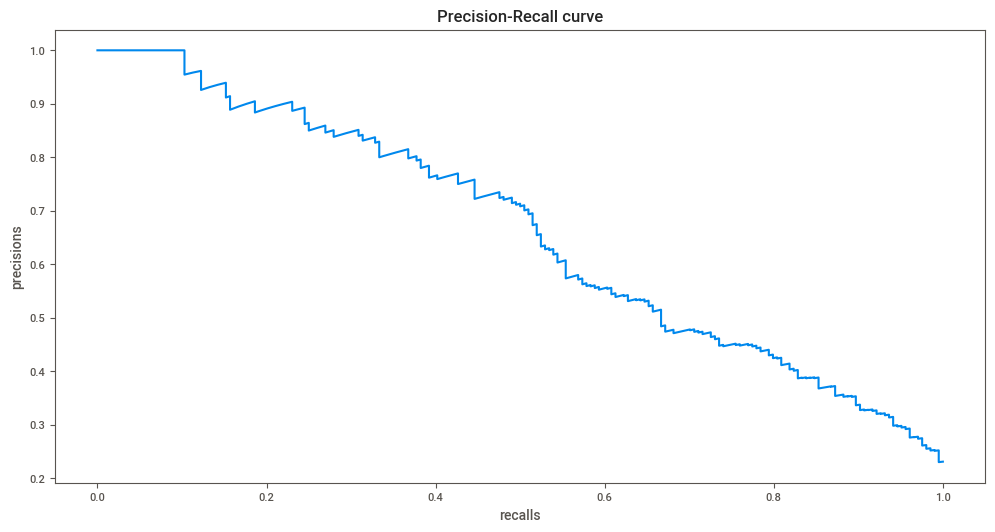

In [43]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [44]:
average_precision_score(y_test, y_pred_proba)

0.6608439302434812

GridSearch 

In [45]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam

In [46]:
def build_classifier(optimizer,learn_rate):
    tf.random.set_seed(42)
    classifier = Sequential()
    classifier.add(Dense(units=16, activation='relu'))
    classifier.add(Dense(units=8, activation='relu'))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer(learn_rate),
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [47]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [48]:
classifier = KerasClassifier(build_fn=build_classifier, validation_split = 0.1, epochs=150)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Adadelta, Nadam],
    'learn_rate': [0.001, 0.003]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train,
                                         y_train,
                                         class_weight=class_weights)

Epoch 1/150
64/64 [==============================] - 1s 3ms/step - loss: 0.6674 - recall: 0.5593 - val_loss: 0.6126 - val_recall: 0.6685
Epoch 2/150
64/64 [==============================] - 0s 1ms/step - loss: 0.6263 - recall: 0.6404 - val_loss: 0.6145 - val_recall: 0.7680
Epoch 3/150
64/64 [==============================] - 0s 1ms/step - loss: 0.6011 - recall: 0.6810 - val_loss: 0.5666 - val_recall: 0.7182
Epoch 4/150
64/64 [==============================] - 0s 1ms/step - loss: 0.5806 - recall: 0.7010 - val_loss: 0.5701 - val_recall: 0.7680
Epoch 5/150
64/64 [==============================] - 0s 1ms/step - loss: 0.5668 - recall: 0.7155 - val_loss: 0.4974 - val_recall: 0.7017
Epoch 6/150
64/64 [==============================] - 0s 1ms/step - loss: 0.5519 - recall: 0.7100 - val_loss: 0.4610 - val_recall: 0.6740
Epoch 7/150
64/64 [==============================] - 0s 1ms/step - loss: 0.5396 - recall: 0.7331 - val_loss: 0.4879 - val_recall: 0.7624
Epoch 8/150
64/64 [======================

64/64 [==============================] - 0s 1ms/step - loss: 0.4429 - recall: 0.7827 - val_loss: 0.4265 - val_recall: 0.8287
Epoch 120/150
64/64 [==============================] - 0s 1ms/step - loss: 0.4422 - recall: 0.7869 - val_loss: 0.4201 - val_recall: 0.8287
Epoch 121/150
64/64 [==============================] - 0s 1ms/step - loss: 0.4417 - recall: 0.7851 - val_loss: 0.4665 - val_recall: 0.8619
Epoch 122/150
64/64 [==============================] - 0s 1ms/step - loss: 0.4480 - recall: 0.7887 - val_loss: 0.3590 - val_recall: 0.7403
Epoch 123/150
64/64 [==============================] - 0s 1ms/step - loss: 0.4458 - recall: 0.7803 - val_loss: 0.3907 - val_recall: 0.7845
Epoch 124/150
64/64 [==============================] - 0s 2ms/step - loss: 0.4422 - recall: 0.7718 - val_loss: 0.4060 - val_recall: 0.8122
Epoch 125/150
64/64 [==============================] - 0s 1ms/step - loss: 0.4434 - recall: 0.7827 - val_loss: 0.4068 - val_recall: 0.8232
Epoch 126/150
64/64 [====================

In [49]:
grid_model.best_score_

0.7722863026274048

In [50]:
grid_model.best_params_

{'batch_size': 128,
 'learn_rate': 0.003,
 'optimizer': keras.optimizer_v2.adam.Adam}

In [51]:
y_pred = grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[667 129]
 [ 56 148]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       796
           1       0.53      0.73      0.62       204

    accuracy                           0.81      1000
   macro avg       0.73      0.78      0.75      1000
weighted avg       0.84      0.81      0.82      1000



ROC and AUC for grid_model

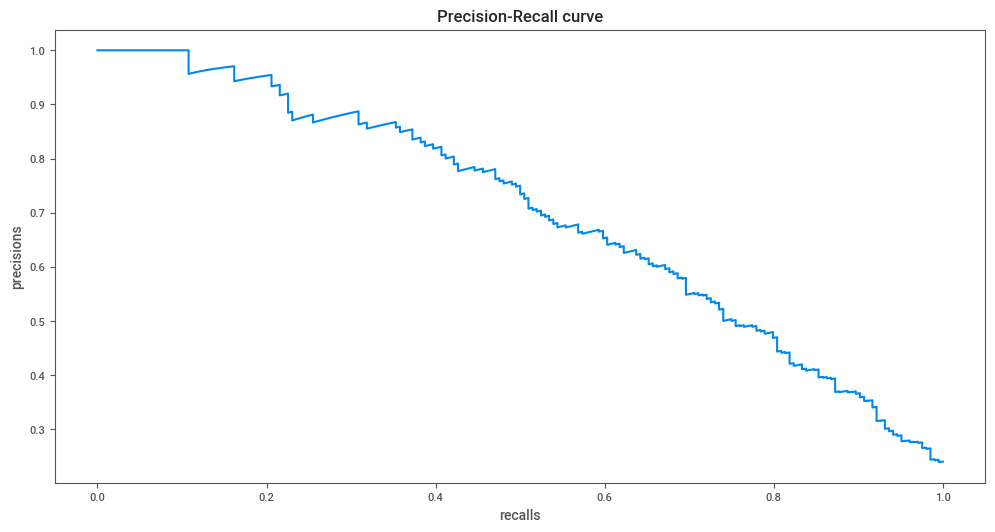

In [52]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [53]:
average_precision_score(y_test, y_pred_proba)

0.6996735348500553

Final Model and Model Deployment

In [54]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [55]:
tf.random.set_seed(42)
model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.003),
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          batch_size=128,
          epochs=200,
          verbose=1,
          class_weight=class_weights)

Epoch 1/200
71/71 [==============================] - 1s 3ms/step - loss: 0.6599 - recall: 0.5428 - val_loss: 0.6536 - val_recall: 0.6422
Epoch 2/200
71/71 [==============================] - 0s 1ms/step - loss: 0.6170 - recall: 0.6618 - val_loss: 0.6058 - val_recall: 0.6520
Epoch 3/200
71/71 [==============================] - 0s 1ms/step - loss: 0.5908 - recall: 0.6863 - val_loss: 0.6346 - val_recall: 0.7255
Epoch 4/200
71/71 [==============================] - 0s 1ms/step - loss: 0.5729 - recall: 0.6972 - val_loss: 0.5905 - val_recall: 0.7010
Epoch 5/200
71/71 [==============================] - 0s 1ms/step - loss: 0.5604 - recall: 0.7136 - val_loss: 0.5232 - val_recall: 0.6225
Epoch 6/200
71/71 [==============================] - 0s 1ms/step - loss: 0.5448 - recall: 0.7163 - val_loss: 0.5807 - val_recall: 0.7500
Epoch 7/200
71/71 [==============================] - 0s 1ms/step - loss: 0.5309 - recall: 0.7278 - val_loss: 0.5597 - val_recall: 0.7500
Epoch 8/200
71/71 [======================

<AxesSubplot:>

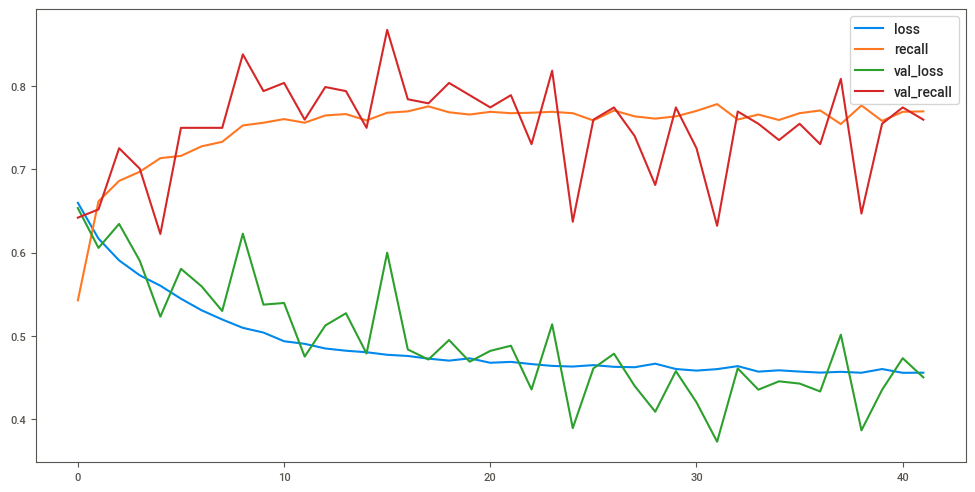

In [56]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [57]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[619 177]
 [ 49 155]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.76      0.58       204

    accuracy                           0.77      1000
   macro avg       0.70      0.77      0.71      1000
weighted avg       0.83      0.77      0.79      1000



In [58]:
model.save('model_churn.h5')

Prediction

In [59]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

CreditScore            619.000
Age                     42.000
Tenure                   2.000
Balance                  0.000
NumOfProducts            1.000
HasCrCard                1.000
IsActiveMember           1.000
EstimatedSalary     101348.880
customer_value           3.000
Geography_Germany        0.000
Geography_Spain          0.000
Gender_Male              0.000
Name: 1, dtype: float64

In [60]:
single_customer1 = single_customer.copy()
single_customer1["Age"] = 40
single_customer1["Balance"] = 50000

In [61]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 12))
single_customer

array([[0.538     , 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 0.5       , 0.        ,
        0.        , 0.        ]])

In [62]:
single_customer1 = scaler.transform(single_customer1.values.reshape(-1, 12))
single_customer1

array([[0.538     , 0.2972973 , 0.2       , 0.20974249, 0.        ,
        1.        , 1.        , 0.50673489, 0.5       , 0.        ,
        0.        , 0.        ]])

In [63]:
model.predict(single_customer)

array([[0.66309845]], dtype=float32)

In [64]:
df["Exited"].iloc[0]

1

In [65]:
model.predict(single_customer1) 

array([[0.4866552]], dtype=float32)

---
---

Comparison with ML

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [67]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [68]:
[10**(-2+i) for i in range(5)]

[0.01, 0.1, 1, 10, 100]

In [69]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [70]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

In [71]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                  scoring='recall').fit(X_train, y_train)

In [72]:
grid_model.best_params_

{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=250,
                        random_state=42),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 250}

In [73]:
grid_model.best_score_

0.7146722055955093

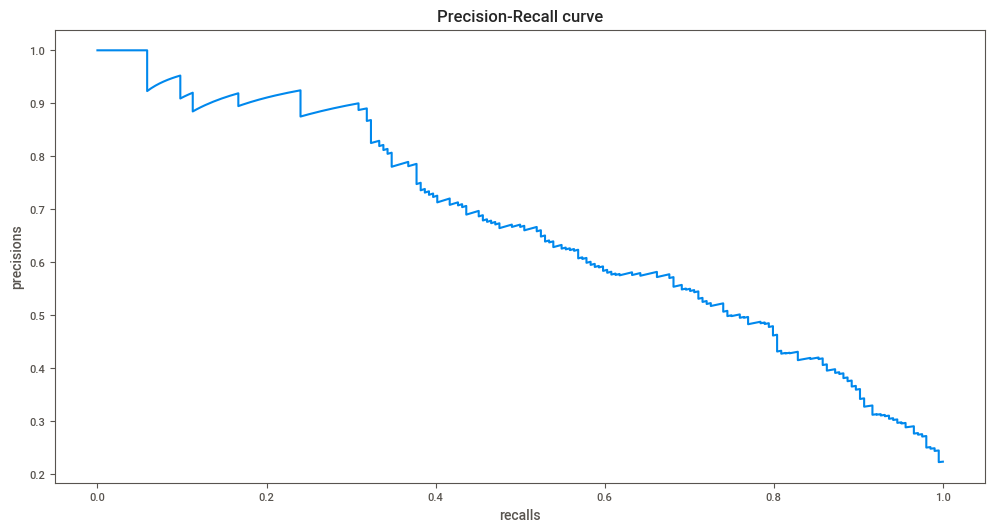

In [74]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='RF')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [75]:
average_precision_score(y_test, y_pred_proba)

0.6695473293906559

In [76]:
y_pred = grid_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[643 153]
 [ 51 153]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       796
           1       0.50      0.75      0.60       204

    accuracy                           0.80      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000



---
---